In [562]:
# imports #
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from stability import stability
from tqdm.auto import trange
from itertools import product

device = 'cuda'
%env CUDA_VISIBLE_DEVICES = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=2


In [563]:
def noisy_batch1d(imgs, timgs):
    """
    :param imgs: original images
    :param timgs: locally translated images / diffeo
    :return: original images, locally translated images, noisy images
    """
    sigma = (timgs - imgs).pow(2).sum([1], keepdim=True).sqrt()
    eta = torch.randn(imgs.shape, device=imgs.device)
    eta = eta / eta.pow(2).sum([1], keepdim=True).sqrt() * sigma
    nimgs = imgs + eta
    return nimgs

class ConstantFiltersCNN(nn.Module):
    def __init__(self, kernel_size, stride, depth, one_filters=0):
        super(ConstantFiltersCNN, self).__init__()
        self.k = kernel_size
        self.s = stride
        self.L = depth
        self.one = one_filters
                
    def forward(self, x):
        
        filters_value = 1 if self.one else self.s / self.k

        for i in range(self.L):
            x = x.unfold(1, self.k, self.s).sum(-1).mul(filters_value).relu()
        return x
    
def receptive_field(f, s, l):
    return f + (f - 1) * (s ** torch.arange(1, l + 1)).sum()

## Compute stabilities of a CNN with constant filters on the two-pixels model

Parameters

In [384]:
N = 512
L = 64
kernel_size = 4
stride = 2
seeds = 1

In [385]:
x = torch.eye(N, device=device)
xd = x.roll(1, 1)

f = ConstantFiltersCNN(kernel_size=kernel_size, stride=stride, depth=L)
f = f.to(device)
nodes, _ = get_graph_node_names(f)
nodes = [n for n in nodes if 'relu' in n]
l = create_feature_extractor(f, return_nodes=nodes)
with torch.no_grad():
    o = l(x)
    od = l(xd)

Traceback (most recent call last):
  File "/home/lpetrini/anaconda3/envs/e2/lib/python3.10/site-packages/torch/fx/graph_module.py", line 622, in wrapped_call
    return super(type(self), self).__call__(*args, **kwargs)
  File "/home/lpetrini/anaconda3/envs/e2/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "<eval_with_key>.159", line 33, in forward
    unfold_7 = relu_6.unfold(1, 4, 2)
RuntimeError: maximum size for tensor at dimension 1 is 2 but size is 4

Call using an FX-traced Module, line 33 of the traced Module's generated forward function:
    relu_6 = mul_6.relu();  mul_6 = None
    unfold_7 = relu_6.unfold(1, 4, 2)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    sum_8 = unfold_7.sum(-1);  unfold_7 = None

    mul_7 = sum_8.mul(0.5);  sum_8 = None



RuntimeError: maximum size for tensor at dimension 1 is 2 but size is 4

In [386]:
df = []

for seed in trange(seeds):
    xn = noisy_batch1d(x, xd)
    xn = xn.relu()
    with torch.no_grad():
        on = l(xn)
        
    for i, k in enumerate(o):
        D, deno = stability(o[k], od[k])
        G, _ = stability(o[k], on[k])

        df.append({
            'seed': seed,
            'layer': k,
            'li': i,
            'D': D,
            'G': G,
            'deno': deno,
        })
df = pd.DataFrame.from_records(df)

  0%|          | 0/1 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/home/lpetrini/anaconda3/envs/e2/lib/python3.10/site-packages/torch/fx/graph_module.py", line 622, in wrapped_call
    return super(type(self), self).__call__(*args, **kwargs)
  File "/home/lpetrini/anaconda3/envs/e2/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "<eval_with_key>.159", line 33, in forward
    unfold_7 = relu_6.unfold(1, 4, 2)
RuntimeError: maximum size for tensor at dimension 1 is 2 but size is 4

Call using an FX-traced Module, line 33 of the traced Module's generated forward function:
    relu_6 = mul_6.relu();  mul_6 = None
    unfold_7 = relu_6.unfold(1, 4, 2)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    sum_8 = unfold_7.sum(-1);  unfold_7 = None

    mul_7 = sum_8.mul(0.5);  sum_8 = None



RuntimeError: maximum size for tensor at dimension 1 is 2 but size is 4

In [380]:
df1 = df[df.apply(lambda a: 'relu' in a.layer, axis=1)]

groups = ['li']
D = df1.groupby(groups)['D'].apply(np.mean)
G = df1.groupby(groups)['G'].apply(np.mean)
deno = df1.groupby(groups)['deno'].apply(np.mean)

Nums and deno

<IPython.core.display.Javascript object>


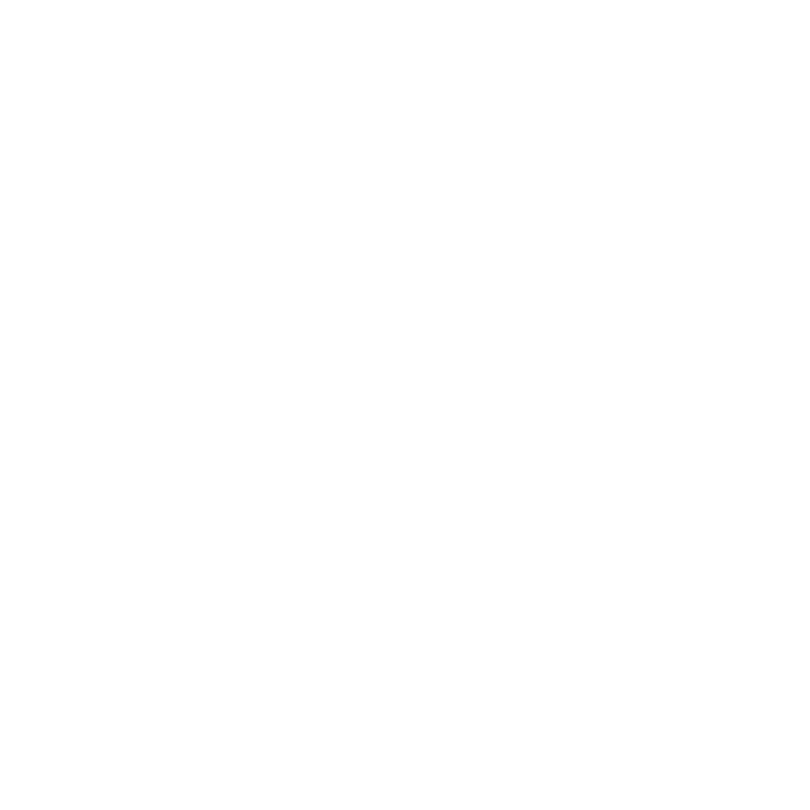

In [381]:
%matplotlib notebook

_, ax = plt.subplots(3, 1, figsize=(5, 5), dpi=180, sharex=True, sharey=True)

ls = torch.arange(1, L + 1).float()

plt.sca(ax[0])
plt.title(f'Conv.net with constant filters, filter size = {kernel_size}, stride = {stride}', fontsize=8) # \n (ReLU at input)
plt.plot(ls, D, 'C0', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -1.5, '--C0', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, 2 ** (-ls), '--C0', label='prediction, $2^k$')
elif kernel_size >= 4:
    plt.plot(ls, kernel_size ** (-ls), '--C0', label='prediction, $f_s^{-k}$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('diffeo numerator')

plt.sca(ax[1])
plt.plot(ls, G, 'C1', label='numerics')
if stride == 1:
    plt.plot(ls, .4 * torch.ones(L), '--C1', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, 2 ** (ls), '--C1', label='prediction, $2^{-k}$')
elif kernel_size >= 4:
    plt.plot(ls, stride ** (ls) / 4, '--C1', label='prediction, $s^{k}$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('noise numerator')

plt.sca(ax[2])
plt.plot(ls, deno, 'C2', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -.5, '--C2', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, torch.ones(L), '--C2', label='prediction, $cnst.$')
elif kernel_size >= 4:
    plt.plot(ls, torch.ones(L), '--C2', label='prediction, $cnst.$')
#     plt.ylim(1e-5, 5)
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('denominator')
plt.xlabel('layer')

plt.tight_layout()

Stabilities: $D_f$, $G_f$, $R_f$

<IPython.core.display.Javascript object>


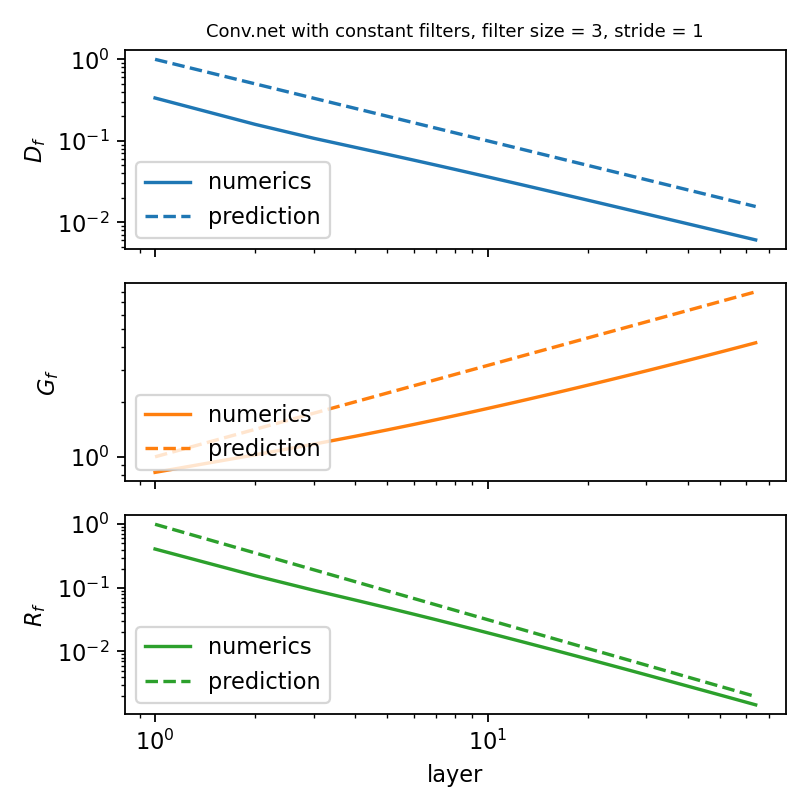

In [382]:
%matplotlib notebook

_, ax = plt.subplots(3, 1, figsize=(5, 5), dpi=180, sharex=True, sharey=False)

ls = torch.arange(1, L + 1).float()

plt.sca(ax[0])
plt.title(f'Conv.net with constant filters, filter size = {kernel_size}, stride = {stride}', fontsize=8) # \n (ReLU at input)
plt.plot(ls, D / deno, 'C0', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -1, '--C0', label='prediction')
elif stride == 2 and kernel_size == 2 or kernel_size >= 3:
    plt.plot(ls, 2 ** (-ls), '--C0', label='prediction, $2^k$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$D_f$')

plt.sca(ax[1])
plt.plot(ls, G / deno, 'C1', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** .5, '--C1', label='prediction')
elif stride == 2 and kernel_size == 2 or kernel_size >= 3:
    plt.plot(ls, 2 ** (ls), '--C1', label='prediction, $2^{-k}$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$G_f$')

plt.sca(ax[2])
plt.plot(ls, D / G, 'C2', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -1.5, '--C2', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, torch.ones(L), '--C2', label='prediction, $cnst.$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$R_f$')
plt.xlabel('layer')

plt.tight_layout()

# Compute receptive field

Parameters

In [519]:
device = 'cpu'
filter_size = 8
stride = 2
depth = 4
input_size = receptive_field(filter_size, stride, depth) + 1

In [520]:
f = ConstantFiltersCNN(filter_size, stride, depth, one_filters=1)
x = torch.eye(input_size, device=device)

In [521]:
layers, _ = get_graph_node_names(f)
layers = [l for l in layers if 'relu' in l]
features = create_feature_extractor(f, return_nodes=layers)
out = features(x)
for k in layers:
    out[k] = out[k].t()

In [522]:
for k in layers:
    i = out[k].shape[0] // 2
    a = out[k][i]
    for ai in a:
        print(int(ai.item()), end=' ')
    print(f' | RF: {sum(a > 0)}')
    
    for ai in a.diff():
        print(int(ai.item()), end=' ')
    print(f' | df: {sum(a.diff().pow(2).int()) / sum(a > 0):.02f}')

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  | RF: 8
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  | df: 0.25
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Measure Df

In [370]:
Df = []
for ki, k in enumerate(layers):
    i = out[k].shape[0] // 2
    a = out[k][i]
    Df.append(sum(a.diff().pow(2)).div(sum(a > 0)).mul((stride / filter_size) ** (2 * ki)).item())

Df

Plot Df

<IPython.core.display.Javascript object>


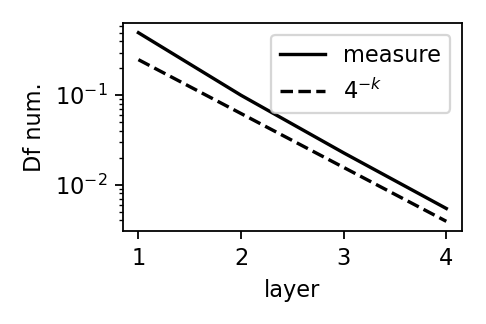

In [553]:
%matplotlib notebook
plt.figure(figsize=(3, 2), dpi=180)
x = torch.arange(1, len(Df) + 1)
plt.plot(x, Df, 'k', label='measure')
plt.plot(x, 4. ** -x, '--k', label='$4^{-k}$')
plt.legend()
plt.yscale('log')
plt.xlabel('layer')
plt.ylabel('Df num.')
plt.tight_layout()

Check intermediate formula

$n_i^{l+1} = \sum_{j=0}^{f-1} n_{i - j s^l}^l$, with $n_i^l = 0 \text{ if } i < 0, i > RF^l$

In [554]:
RF = torch.zeros(len(layers))
for ki, k in enumerate(layers):
    i = out[k].shape[0] // 2
    a = out[k][i]
    RF[ki] = sum(a > 0)

In [555]:
# def n_recursion(n, f, s, l):
#     N = len(n)
#     nn = torch.zeros(N)
#     for i in range(1, N + 1):
# #         for j in range(- (f - 1) // 2, (f - 1) // 2 + 1):
#         for j in range(f - 1):
            
#             q = j * s ** l
# #             if q >= RF[l] or q < 0: continue

#             try:
#                 nn[i] += n[i + q]
#             except:
#                 pass
# #                 print(i, j * s ^ l)
#     return nn

def n_recursion(n, f, s, l):
    N = len(n)
    nn = torch.zeros(N)
    for i in range(N):
#         for j in range(- (f - 1) // 2, (f - 1) // 2 + 1):
        for j in range(f):
#             print(i - j * s ** l)
            try:
                nn[i] += n[i - j * s ** l]
            except:
                pass
#                 print(i, j * s ^ l)
    return nn

In [556]:
N = input_size
x = torch.zeros(N)
x[:filter_size] = 1

torch.set_printoptions(linewidth=1000, edgeitems=100)

for l in range(depth):
    print(x)
    x = n_recursion(x, filter_size, stride, l+1)
print(x)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 1., 2., 2., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 2., 2., 1., 1., 0., 0., 0., 0., 0.,

In [557]:
for k in out:
    print(out[k][out[k].shape[0] // 2])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Check new formula 31.08

In [560]:
f = 8
s = 2
l = 2

In [561]:
L = 4
for l in range(L):

    RFl = receptive_field(f, s, l)

    n = torch.zeros(RFl + 1)
    for i in range(len(n)):
        for J in product(*[range(f) for _ in range(l)]):
            J = torch.tensor(J)
            S = s ** torch.arange(1, l + 1)
            if i - J.mul(S).sum() == f:
    #             print(J, '-1')
                n[i] -= 1
            if i - J.mul(S).sum() == 0:
    #             print(J, '+1')
                n[i] += 1
    print(n.pow(2).sum().int().item())
n

2.0
8.0
56.0
432.0
3424.0


tensor([ 1.,  0.,  1.,  0.,  2.,  0.,  2.,  0.,  3.,  0.,  3.,  0.,  4.,  0.,  4.,  0.,  5.,  0.,  5.,  0.,  6.,  0.,  6.,  0.,  7.,  0.,  7.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  8.,  0.,  7.,  0.,  7.,  0.,  6.,  0.,  6.,  0.,  5.,  0.,  5.,  0.,  4.,  0.,  4.,  0.,  3.,  0.,  3.,  0.,  2.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0., -2.,  0., -2.,  0., -3.,  0., -3.,  0., -4.,  0., -4.,  0., -5.,  0., -5.,  0., -6.,  0., -6.,  0., -7.,  0., -7.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -8.,  0., -7.,  0., -7.,  0., -6.,  0.,
  